<a href="https://colab.research.google.com/github/crazyandiee/Customer-Churn-Prediction-System-with-Dashboard-Web-App/blob/main/notebooks/CUSTOMER_CHURN_MODEL_INTERPRETATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
import numpy as np


In [12]:
df = pd.read_csv("/content/telco_cleaned.csv")
model = joblib.load("/content/churn_best_model.pkl")

print("✅ Data and Model Loaded Successfully!")
print("Data shape:", df.shape)
print("Model Type:", type(model))

# Separate features and target
X = df.drop(columns=["Churn", "tenure_group"])
y = df["Churn"]

✅ Data and Model Loaded Successfully!
Data shape: (7043, 36)
Model Type: <class 'sklearn.linear_model._logistic.LogisticRegression'>


In [19]:
# Detect model type and use appropriate SHAP explainer
if "xgboost" in str(type(model)).lower() or "forest" in str(type(model)).lower():
    print("\n🌳 Using TreeExplainer (for XGBoost / RandomForest)")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X)
elif "logistic" in str(type(model)).lower():
    print("\n📈 Using LinearExplainer (for Logistic Regression)")
    explainer = shap.LinearExplainer(model, X)
    shap_values = explainer.shap_values(X)
else:
    print("\n⚙️ Using KernelExplainer (fallback, slower)")
    sample = shap.sample(X, 100)  # reduce computation
    explainer = shap.KernelExplainer(model.predict_proba, sample)
    shap_values = explainer.shap_values(X[:200])


📈 Using LinearExplainer (for Logistic Regression)



📊 SHAP Summary Plot (Feature Importance)


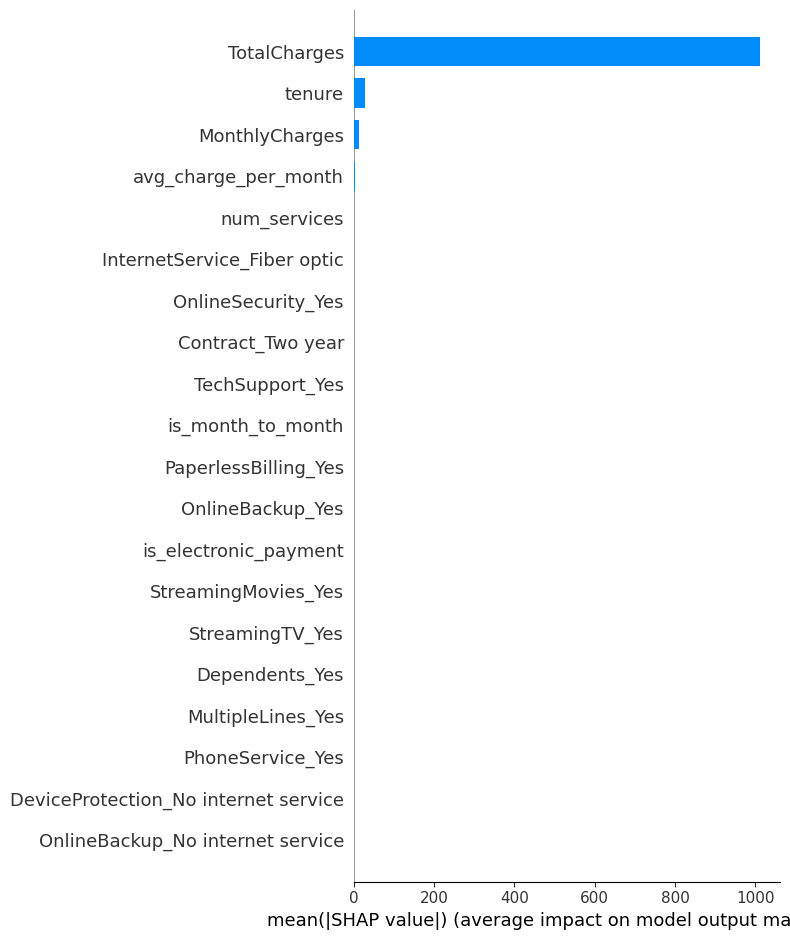

In [20]:
#Global Feature Importance
try:
    print("\n📊 SHAP Summary Plot (Feature Importance)")
    shap.summary_plot(shap_values, X, plot_type="bar")
    plt.show()
except Exception as e:
    print("⚠️ Could not plot SHAP summary:", e)

⚠️ Could not plot detailed summary: loop of ufunc does not support argument 0 of type float which has no callable rint method


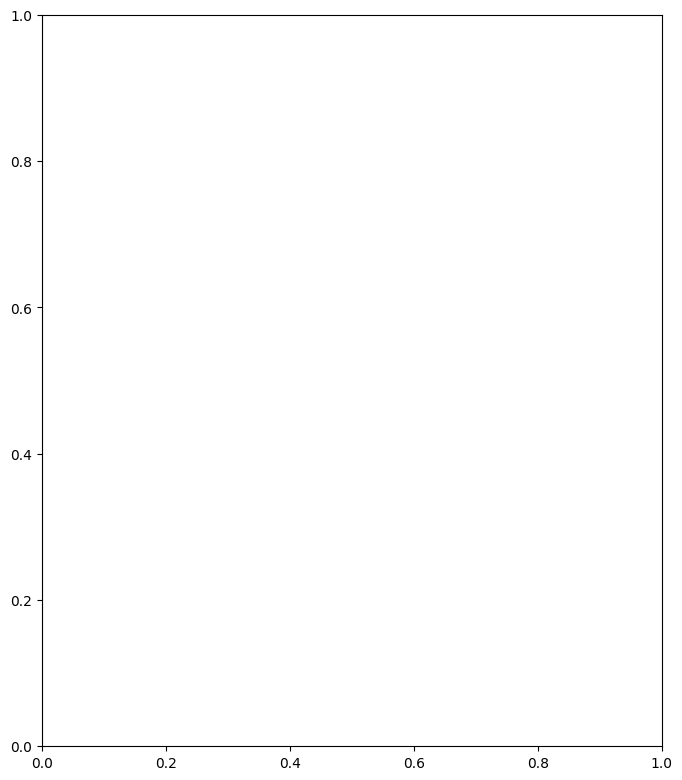

In [21]:
#Detailed Feature Impact

try:
    shap.summary_plot(shap_values, X)
    plt.show()
except Exception as e:
    print("⚠️ Could not plot detailed summary:", e)


🧍 Explaining Customer #42


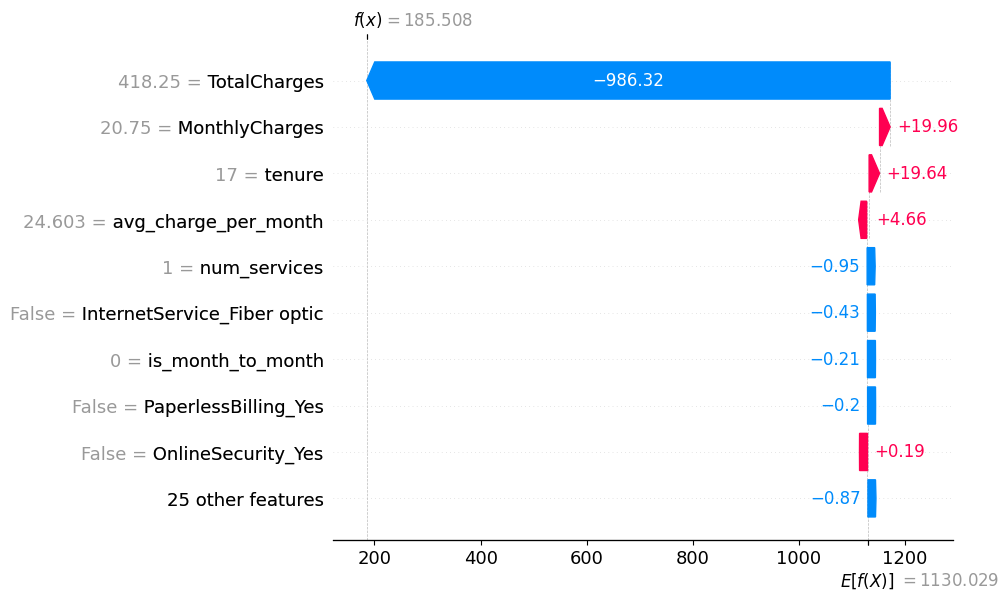

In [23]:
#Individual Prediction Explanation
sample_index = 42 #change this for different sample
print(f"\n🧍 Explaining Customer #{sample_index}")

try:
    shap.waterfall_plot(shap.Explanation(values=shap_values[sample_index],
                                         base_values=getattr(explainer, 'expected_value', 0),
                                         feature_names=X.columns,
                                         data=X.iloc[sample_index]))
except Exception as e:
    print("⚠️ Could not generate waterfall plot:", e)

In [26]:
if isinstance(shap_values, list):  # handle linear explainer returning list
    sv = shap_values[0]
else:
    sv = shap_values.values if hasattr(shap_values, "values") else shap_values

shap_importance = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": np.abs(sv).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

print("\n🏆 Top 10 Features Driving Churn:")
print(shap_importance.head(10))


🏆 Top 10 Features Driving Churn:
                        feature mean_abs_shap
3                  TotalCharges    1010.50227
1                        tenure     27.545569
2                MonthlyCharges     13.339901
7          avg_charge_per_month      3.694088
4                  num_services      0.717406
14  InternetService_Fiber optic      0.603316
17           OnlineSecurity_Yes      0.230768
29            Contract_Two year      0.208443
23              TechSupport_Yes        0.2053
6             is_month_to_month      0.193688
